<a href="https://colab.research.google.com/github/varnikaaavyas/Time-Series-Analysis/blob/main/Exponential_Smoothing_based_Forecasting_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf, acf
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv(r"https://raw.githubusercontent.com/ejgao/Time-Series-Datasets/master/monthly-beer-production-in-austr.csv")
df.rename(columns={'Monthly beer production' :'MBP'}, inplace = True)
df

,Month,MBP
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9
...,...,...
471,1995-04,127.0
472,1995-05,151.0
473,1995-06,130.0
474,1995-07,119.0


In [ ]:
df.Month = pd.to_datetime(df.Month)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Month   476 non-null    datetime64[ns]
 1   MBP     476 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.6 KB


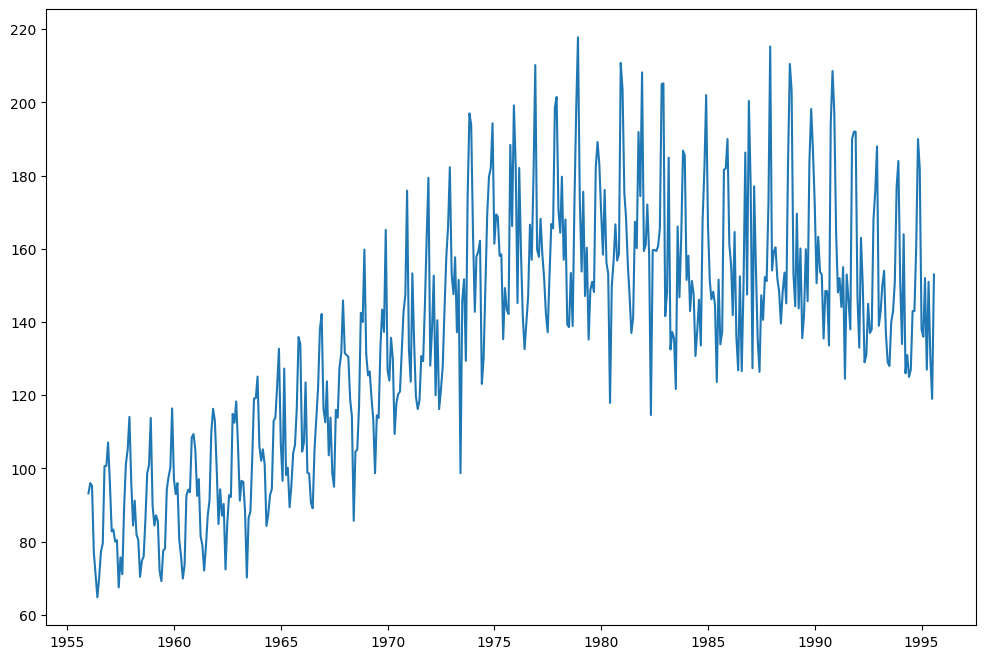

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(df.Month, df['MBP'].values)
plt.show()

In [ ]:
def statistical_test(series):
    # ADF test
    from statsmodels.tsa.stattools import adfuller

    result = adfuller(series, autolag = 'AIC')
    print('\n p-value:', result[1])


    if result[1] > 0.05:
        print("H0 is accepted: Series is NON-STATIONARY")
    else:
        print("H1 is accepted: Series is STATIONARY")

    #KPSS test
    from statsmodels.tsa.stattools import kpss

    kpss_test = kpss(series)


    print('\n p-value:', kpss_test[1])


    if kpss_test[1] > 0.05:
        print("H0 is accepted: Series is STATIONARY")
    else:
        print("H1 is accepted: Series is NON-STATIONARY")


    # Final result
    if result[1] > 0.05 and kpss_test[1] < 0.05:
        print("\nFinal: Series is NON-stationary")
    elif result[1] > 0.05 and kpss_test[1] > 0.05:
        print("\nFinal: Series is difference stationary")
    elif result[1] < 0.05 and kpss_test[1] > 0.05:
        print("\nFinal: Series is trend stationary")
    elif result[1] < 0.05 and kpss_test[1] < 0.05:
        print("\nFinal: Series is strictly stationary")


# ADF and KPSS for humidity

print("ADF and KPSS: ")
print(statistical_test(df["MBP"].values))

ADF and KPSS: 

 p-value: 0.17762099829132505
H0 is accepted: Series is NON-STATIONARY

 p-value: 0.01
H1 is accepted: Series is NON-STATIONARY

Final: Series is NON-stationary
None


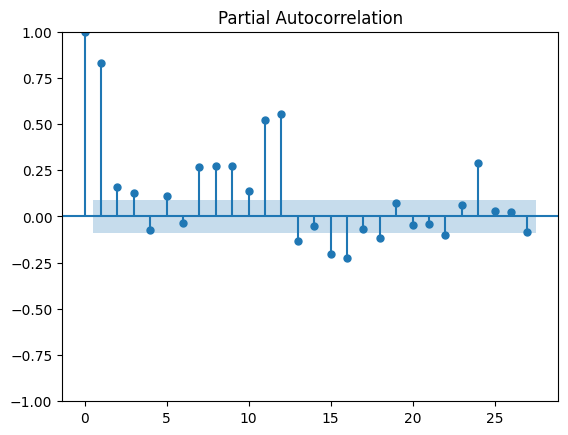

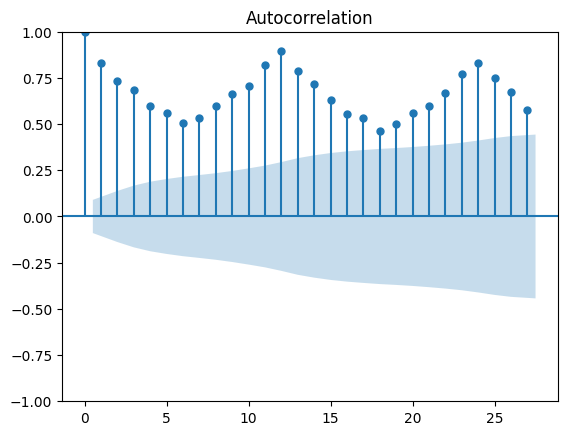

In [ ]:

plot_pacf(df["MBP"].values)
plt.show()

plot_acf(df["MBP"].values)
plt.show()

# We can see, that there is trend and seasonlity of 12 months in the dataset

In [ ]:
def performance_metrics(forecast, actual):
    mape = np.mean((np.abs(actual - forecast)/actual)*100)
    me = np.mean(actual - forecast)
    mpe = np.mean(((forecast-actual)/actual)*100)
    mae = np.mean(np.abs(actual - forecast))
    rmse = np.sqrt(np.mean(forecast - actual)**2)
    corr = np.corrcoef(actual, forecast)[0,1]
    mins = np.amin(np.hstack([actual[:,None], forecast[:, None]]), axis = 1)
    maxs = np.amax(np.hstack([actual[:,None], forecast[:, None]]), axis = 1)
    minmax = 1 - np.mean(mins/maxs)
    acf1 = acf(actual - forecast)[1]
    return({'mape': mape, 'me': me, 'mae': mae, 'mpe':mpe, 'rmse': rmse, 'acf1': acf1,
    'corr': corr, 'minmax': minmax})

In [ ]:
df["MBP"]=df["MBP"].diff(1) #Remove trend

df["MBP"]=df["MBP"].diff(12) #Remove Seasonality

df=df.dropna()

df=df.reset_index(drop=True)

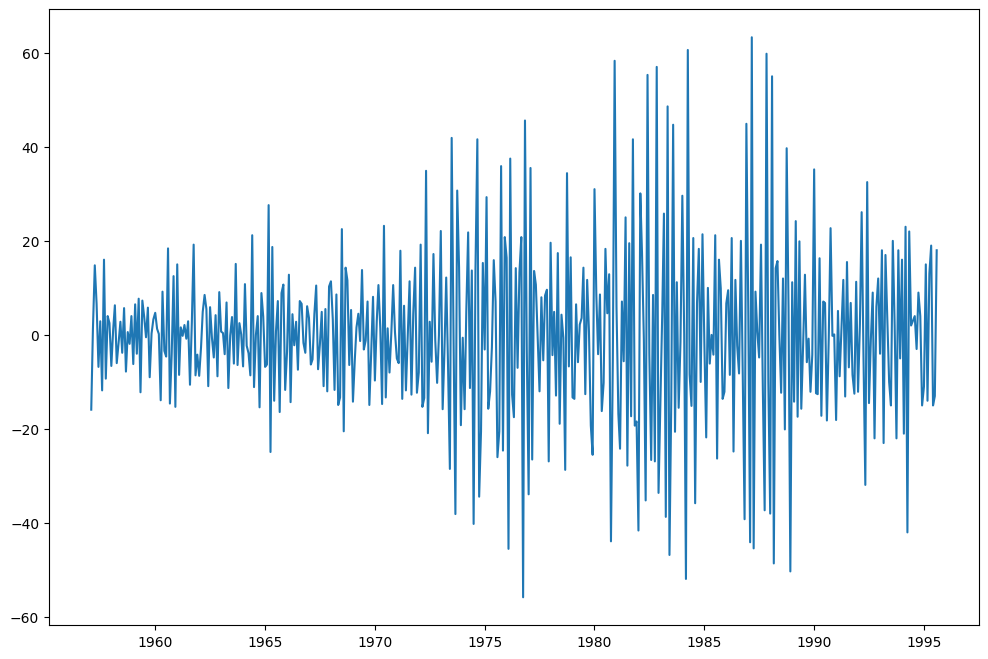

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(df.Month, (df["MBP"].values))
plt.show()

In [ ]:
# train - test split

train = df["MBP"][:int(0.7*len(df))]
test = df["MBP"][int(0.7*len(df)):]

**Simple Exponential Smoothing**

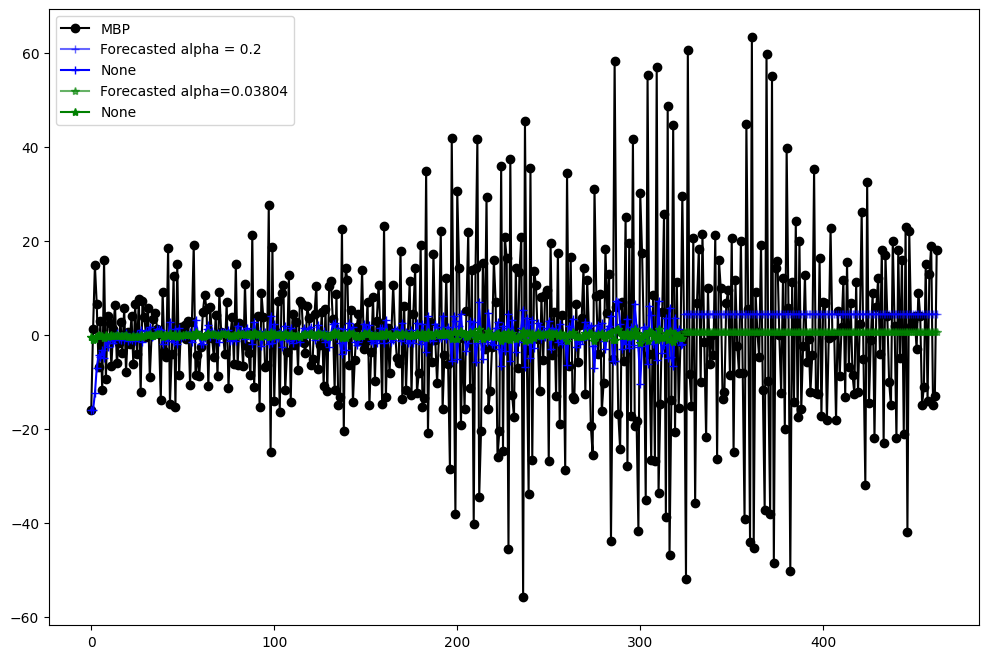

In [ ]:
plt.figure(figsize = (15,8))

n=len(test) # forecast period
alpha=0.2

#First Instance
model1 = SimpleExpSmoothing(train).fit(smoothing_level=alpha,optimized=False)
forecast1 = model1.forecast(n).rename('alpha=' + str(alpha))

#Second Instance
model2 = SimpleExpSmoothing(train).fit()
forecast2 = model2.forecast(n).rename('alpha=%s'%model2.model.params['smoothing_level'])


#After creating model we will visualize the plot
ax = df["MBP"].plot(marker='o', color='black', figsize=(12,8), legend=True)


#Plot for alpha =0.2
forecast1.plot(marker='+', ax=ax, color='blue', legend=True, label = "Forecasted alpha = 0.2", alpha = 0.6)
model1.fittedvalues.plot(marker='+', ax=ax, color='blue')


#Plot for alpha = Optimized by statsmodel
forecast2.plot(marker='*', ax=ax, color='green', legend=True, label = 'Forecasted alpha=%s'%model2.model.params['smoothing_level'].round(5), alpha = 0.6)
model2.fittedvalues.plot(marker='*', ax=ax, color='green')

plt.legend()
plt.show()



In [ ]:
performance_metrics(forecast1, test)

{'mape': -220900108986691.78,
 'me': -4.3627398795207,
 'mae': 16.581197716543368,
 'mpe': -220900108986746.7,
 'rmse': 4.3627398795207,
 'acf1': -0.5579540859471193,
 'corr': nan,
 'minmax': 2.6744823327992036}

In [ ]:
performance_metrics(forecast2, test)

{'mape': -26434499288030.633,
 'me': -0.5214435676427589,
 'mae': 16.162267201041168,
 'mpe': -26434499288118.77,
 'rmse': 0.5214435676427589,
 'acf1': -0.5579540859471193,
 'corr': 9.677894786742787e-18,
 'minmax': 16.41625106286663}

**Double Expoential Smoothing**

In [ ]:
df = pd.read_csv(r"https://raw.githubusercontent.com/ejgao/Time-Series-Datasets/master/monthly-beer-production-in-austr.csv")

In [ ]:
df["Monthly beer production"]=df["Monthly beer production"].diff(12) #Remove Seasonality
df=df.dropna()
df=df.reset_index(drop=True)

In [ ]:
# train - test split in 70:30

train = df["Monthly beer production"][:int(0.7*len(df))]
test = df["Monthly beer production"][int(0.7*len(df)):]

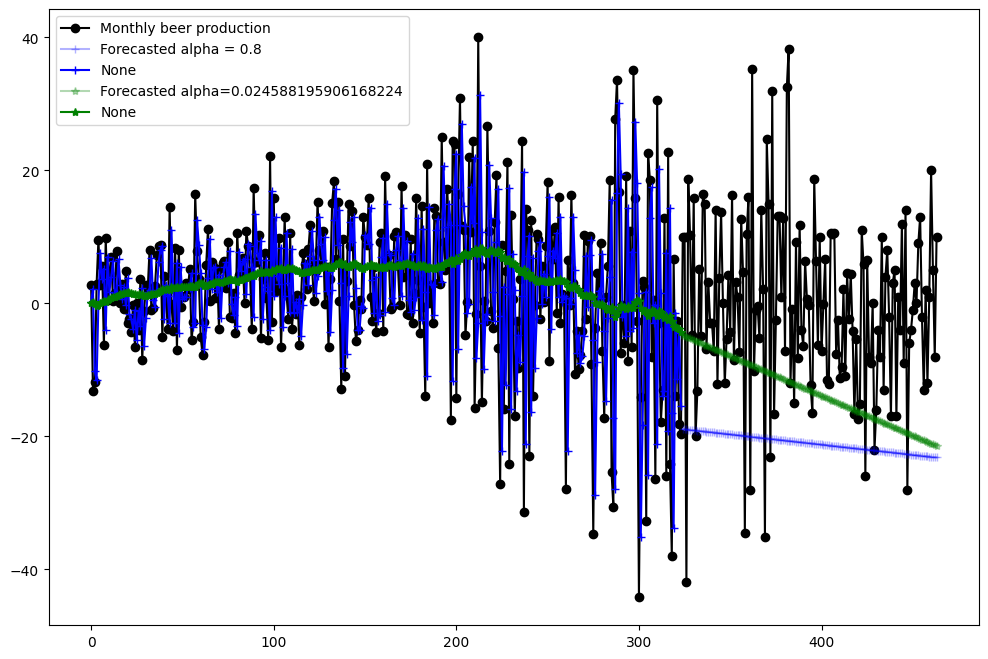

In [ ]:
plt.figure(figsize = (18,10))

n=len(test) #define forecast period
alpha=0.8
trend = "add"


#First Instance
model1 = ExponentialSmoothing(train, trend).fit(smoothing_level=alpha)
forecast1 = model1.forecast(n).rename('alpha=' + str(alpha))



#Second Instance
model2 = ExponentialSmoothing(train, trend = trend).fit()
forecast2 = model2.forecast(n).rename('alpha=%s'%model2.model.params['smoothing_level'])


#After creating model we will visualize the plot
ax = df["Monthly beer production"].plot(marker='o', color='black', figsize=(12,8), legend=True)


#Plot for alpha =0.2
forecast1.plot(marker='+', ax=ax, color='blue', legend=True, label = "Forecasted alpha = 0.8", alpha = 0.3)
model1.fittedvalues.plot(marker='+', ax=ax, color='blue')


#Plot for alpha=Optimized by statsmodel
forecast2.plot(marker='*', ax=ax, color='green', legend=True, label = 'Forecasted alpha=%s'%model2.model.params['smoothing_level'], alpha = 0.3)
model2.fittedvalues.plot(marker='*', ax=ax, color='green')

plt.legend()
plt.show()



In [ ]:
performance_metrics(forecast1, test)

{'mape': inf,
 'me': 20.536178289764422,
 'mae': 21.58493479553129,
 'mpe': -inf,
 'rmse': 20.536178289764422,
 'acf1': -0.24959831212862996,
 'corr': 0.08866920383816897,
 'minmax': inf}

In [ ]:
performance_metrics(forecast2, test)

{'mape': inf,
 'me': 12.63035849206378,
 'mae': 15.317779531014642,
 'mpe': -inf,
 'rmse': 12.63035849206378,
 'acf1': -0.165064386210523,
 'corr': 0.088669203838169,
 'minmax': inf}

**Triple Expoential Smoothing**

In [ ]:
df = pd.read_csv(r"https://raw.githubusercontent.com/ejgao/Time-Series-Datasets/master/monthly-beer-production-in-austr.csv")
df

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9
...,...,...
471,1995-04,127.0
472,1995-05,151.0
473,1995-06,130.0
474,1995-07,119.0


In [ ]:
# train - test split

train = df["Monthly beer production"][:int(0.7*len(df))]
test = df["Monthly beer production"][int(0.7*len(df)):]

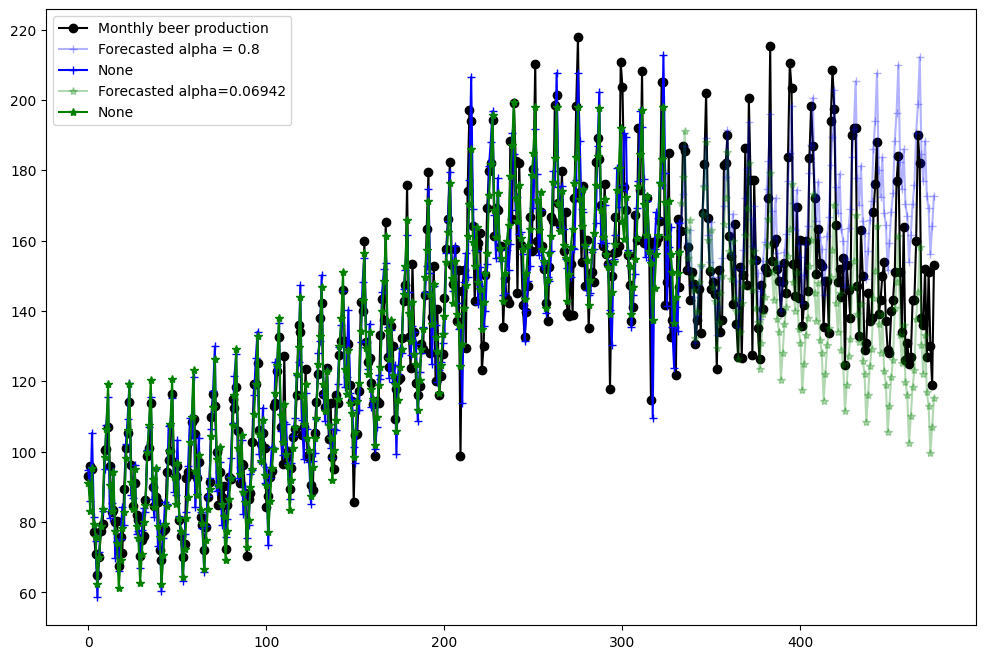

In [ ]:
plt.figure(figsize = (18,10))


n=len(test) #define forecast period
alpha=0.8
trend='add'
seasonal='add'
sPeriod=12


#First Instance
model1 = ExponentialSmoothing(train, trend = trend, seasonal = "add", seasonal_periods = sPeriod).fit(smoothing_level=alpha)
forecast1 = model1.forecast(n).rename('alpha=' + str(alpha))


#Second Instance
model2 = ExponentialSmoothing(train, trend = trend, seasonal = "add", seasonal_periods = sPeriod).fit()
forecast2 = model2.forecast(n).rename('alpha=%s'%model2.model.params['smoothing_level'])



#After creating model we will visualize the plot
ax = df["Monthly beer production"].plot(marker='o', color='black', figsize=(12,8), legend=True)




#Plot for alpha =0.8
forecast1.plot(marker='+', ax=ax, color='blue', legend=True, label = "Forecasted alpha = 0.8", alpha = 0.3)
model1.fittedvalues.plot(marker='+', ax=ax, color='blue')




#Plot for alpha=Optimized by statsmodel
forecast2.plot(marker='*', ax=ax, color='green', legend=True, label = 'Forecasted alpha=%s'%model2.model.params['smoothing_level'].round(5) , alpha = 0.3)
model2.fittedvalues.plot(marker='*', ax=ax, color='green')

plt.legend()
plt.show()

In [ ]:
n=len(test) #forecast period
alpha=0.8
trend='add'
sPeriod=12



#First Instance
model3 = ExponentialSmoothing(train, trend = trend, seasonal = "add", seasonal_periods = sPeriod).fit()
forecast3 = model1.forecast(n).rename('alpha=%s'%model2.model.params['smoothing_level'])



#Second Instance
model4 = ExponentialSmoothing(train, trend = trend, seasonal = "mul", seasonal_periods = sPeriod).fit()
forecast4 = model2.forecast(n).rename('alpha=%s'%model2.model.params['smoothing_level'])

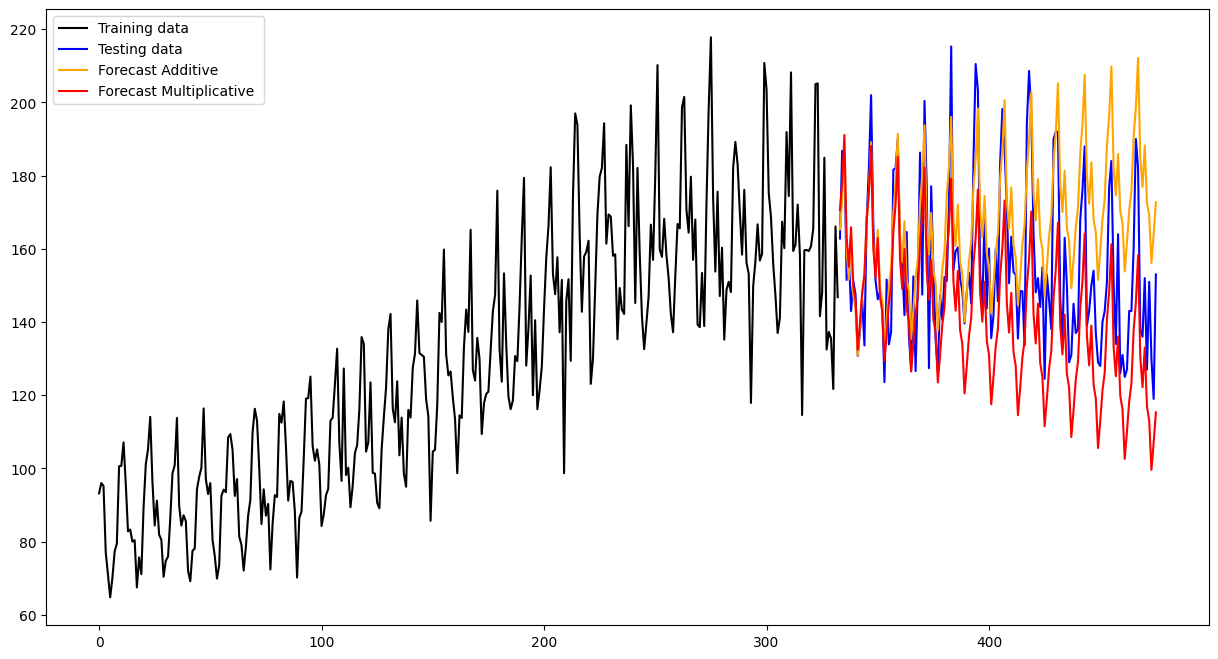

In [ ]:
plt.figure(figsize=(15,8))

plt.plot(train,color='black', label='Training data')

plt.plot(test, color='blue', label='Testing data')

plt.plot(forecast3, color='orange', label='Forecast Additive')

plt.plot(forecast4, color='red', label='Forecast Multiplicative ')


plt.legend()

In [ ]:
performance_metrics(forecast1, test)

{'mape': 11.048103341353896,
 'me': -12.562785607266726,
 'mae': 16.16455658425606,
 'mpe': 9.098267489956225,
 'rmse': 12.562785607266726,
 'acf1': 0.4303648770652172,
 'corr': 0.6863165809707525,
 'minmax': 0.0943873335243608}

In [ ]:
performance_metrics(forecast2, test)

{'mape': 10.394445480757893,
 'me': 13.545116874774227,
 'mae': 16.472325686709816,
 'mpe': -8.30565848684193,
 'rmse': 13.545116874774227,
 'acf1': 0.30523734073430064,
 'corr': 0.752542362653687,
 'minmax': 0.10291820787914963}

In [ ]:
print("Additive seasonality: \n",performance_metrics(forecast3, test))

Additive seasonality: 
 {'mape': 11.048103341353896, 'me': -12.562785607266726, 'mae': 16.16455658425606, 'mpe': 9.098267489956225, 'rmse': 12.562785607266726, 'acf1': 0.4303648770652172, 'corr': 0.6863165809707525, 'minmax': 0.0943873335243608}


In [ ]:
print("Multiplicative seasonality: \n",performance_metrics(forecast4, test))

Multiplicative seasonality: 
 {'mape': 10.394445480757893, 'me': 13.545116874774227, 'mae': 16.472325686709816, 'mpe': -8.30565848684193, 'rmse': 13.545116874774227, 'acf1': 0.30523734073430064, 'corr': 0.752542362653687, 'minmax': 0.10291820787914963}
